In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import salem
import xarray as xr
# Some defaults
cmap = plt.get_cmap('RdBu_r')
import ipdb
from utils import constants as cnst, u_darrays as uda
import shapely.geometry as shpg
from scipy.stats import gaussian_kde, linregress

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
chirps = '/media/ck/Elements/SouthAmerica/CHIRPS/chirps-v2.0.daily.peru.nc'

fpath = cnst.network_data + 'figs/HUARAZ/'

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
isbuffer = [-79, -74, -12, -6]

sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

ca = xr.open_dataarray(chirps).sel(longitude=slice(isbuffer[0], isbuffer[1]), latitude=slice(isbuffer[2], isbuffer[3])).salem.roi(shape=sdf)
# Rio Santa basin only


In [4]:
def readERA(file):

    u200orig = xr.open_dataarray(file)
    #u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
u200 = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/u200_15UTC_1981-2019_peru_big.nc')
isvalley = [-78.3,-76.8,-10.7,-8]
isjet = [-75.5,-74.5,-8.5,-6.5]
u200 = u200.sel(longitude=slice(isvalley[0], isvalley[1]), latitude=slice(isvalley[2], isvalley[3])).mean(['latitude', 'longitude'])
v850 = readERA('/media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc')
v850 = v850.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3])).mean(['latitude', 'longitude'])

ValueError: dimensions or multi-index levels ['longitude', 'latitude'] do not exist

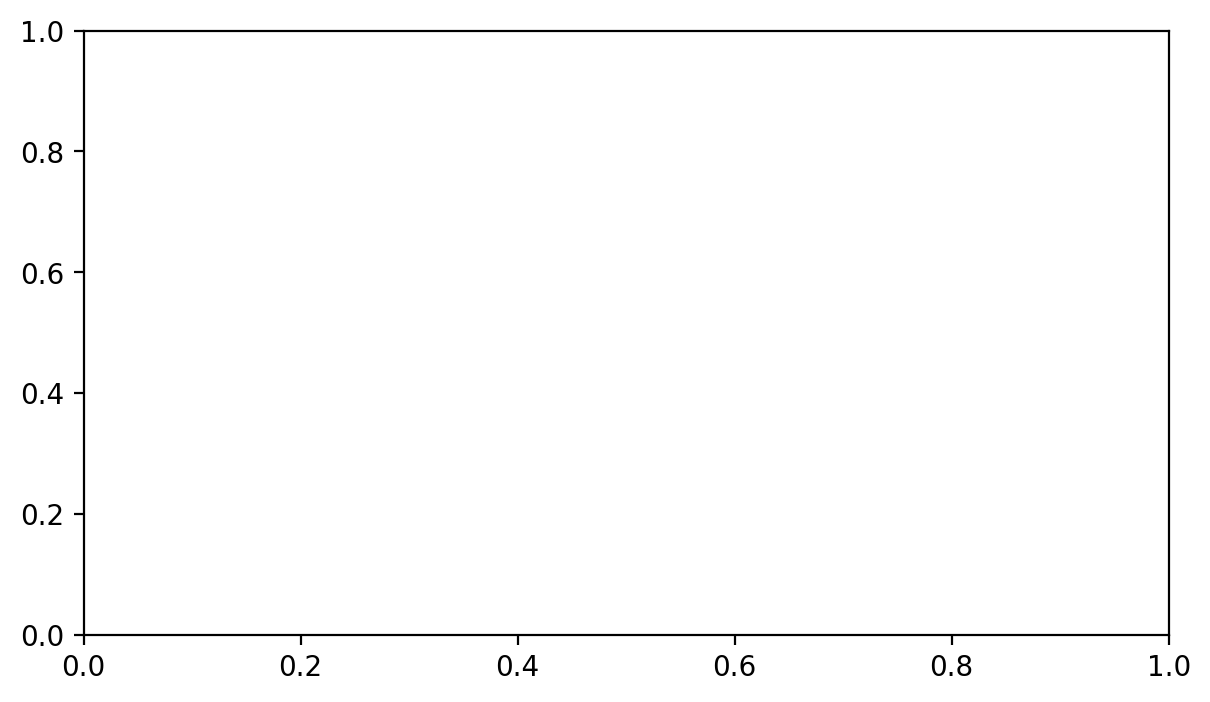

In [7]:
map = ca.salem.get_map()
f = plt.figure(figsize=(7,4), dpi=200)

ax = f.add_subplot(111)

map.set_data(v850.sel(longitude=slice(isjet[0], isjet[1]), latitude=slice(isjet[2], isjet[3]))[2000,:,:])
coord = isjet
geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
map.set_geometry(geom, zorder=99, color='darkorange', linewidth=3, linestyle='--', alpha=0.1)
map.visualize()

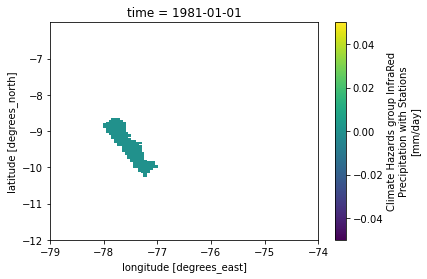

In [6]:
ca[0,:,:].plot()

In [7]:
ca_rainy = ca.sum(['latitude', 'longitude'])
#ca_rainy = ca_rainy.where(ca_rainy>0.1, drop=True)

In [8]:
np.unique(ca_rainy['time.year'])

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019])

In [9]:
ca_rainy.shape

(13999,)

In [10]:
# u200roll = u200.rolling(time=3, min_periods=1, center=True).mean(dim='time') # time=3
# v850roll = v850.rolling(time=3, min_periods=1, center=True).mean(dim='time')
# chroll = ca_rainy.rolling(time=3, min_periods=1, center=True).mean(dim='time') # time=3

# u200roll = u200roll[(u200roll['time.month']>=9) | (u200roll['time.month']<=4)]
# v850roll = v850roll[(v850roll['time.month']>=9) | (v850roll['time.month']<=4)]
# chroll = chroll[(chroll['time.month']>=9) | (chroll['time.month']<=4)]

# posgrid200 = np.intersect1d(u200roll.time.values, chroll.time.values)
# posgrid850 = np.intersect1d(v850roll.time.values, chroll.time.values)

# u200ca = u200roll.sel(time=posgrid200)
# v850ca = v850roll.sel(time=posgrid850)

# cau200 = chroll.sel(time=posgrid200)
# cav850 = chroll.sel(time=posgrid850)

In [11]:
ca_rainy = ca_rainy[(ca_rainy['time.month']>=9) | (ca_rainy['time.month']<=4)]

posgrid200 = np.intersect1d(u200.time.values, ca_rainy.time.values)
posgrid850 = np.intersect1d(v850.time.values, ca_rainy.time.values)

u200ca = u200.sel(time=posgrid200)
v850ca = v850.sel(time=posgrid850)

cau200 = ca_rainy.sel(time=posgrid200)
cav850 = ca_rainy.sel(time=posgrid850)

In [12]:
np.all(cau200.time==cav850.time)

<xarray.DataArray 'time' ()>
array(True)

In [13]:
np.all(u200ca.time==v850ca.time)

<xarray.DataArray 'time' ()>
array(True)

In [14]:
def perc_1d_binning(data, xvar, xbins):
    import warnings
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['data'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        poss_ds = (xvar > shl) & (xvar <= xbins[issh + 1])
        valdat = (data[poss_ds])[np.isfinite(data[poss_ds])]
        #dat = np.percentile(valdat, perc)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            dat = np.nanmean(valdat)

        outdic['data'].append(dat)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

In [15]:
def binning_loop(x, y):
    dic = {'corr': [], 'pval' : [], 'slope' : []}

    for ids,year in enumerate(range(1984,2019)):

        xx = x.sel(time=slice(str(year-1)+'-09-01',str(year)+'-04-30'))
        yy = y.sel(time=slice(str(year-1)+'-09-01',str(year)+'-04-30'))
        
        #ipdb.set_trace()

        cadic = perc_1d_binning(xx,yy, xbins=np.arange(-15,15,1))
        isval = np.isfinite(cadic['data'])
        b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

    #     ax = f.add_subplot(9,4,ids+1)
    #     ax.scatter(cadic['xbins'], cadic['data'])
    #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
    #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
        dic['corr'].append(r_value)
        dic['pval'].append(p_value)
        dic['slope'].append(b)
                        
    return dic

In [16]:
u200_stats = binning_loop(cau200, u200ca)

In [17]:
v850_stats = binning_loop(cav850, v850ca)

In [18]:
wind_stats = binning_loop(u200ca, v850ca)

In [19]:
# # f = plt.figure(figsize=(15,12), dpi=300)
# u200_stats = {'corr': [], 'pval' : [], 'slope' : []}

# for ids,y in enumerate(range(1983,2019)):
#     cadic = perc_1d_binning(cau200[cau200['time.year']==y], u200ca[u200ca['time.year']==y], xbins=np.arange(-15,15,1))
#     isval = np.isfinite(cadic['data'])
#     b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

# #     ax = f.add_subplot(9,4,ids+1)
# #     ax.scatter(cadic['xbins'], cadic['data'])
# #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
# #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
#     u200_stats['corr'].append(r_value)
#     u200_stats['pval'].append(p_value)
#     u200_stats['slope'].append(b)

In [20]:
# #f = plt.figure(figsize=(15,12), dpi=300)
# v850_stats = {'corr': [], 'pval' : [], 'slope' : []}
# for ids,y in enumerate(range(1983,2019)):
#     cadic = perc_1d_binning(cav850[cav850['time.year']==y], v850ca[v850ca['time.year']==y], xbins=np.arange(-15,15,1))
#     isval = np.isfinite(cadic['data'])
#     b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

# #     ax = f.add_subplot(9,4,ids+1)
# #     ax.scatter(cadic['xbins'], cadic['data'])
# #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
# #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
#     v850_stats['corr'].append(r_value)
#     v850_stats['pval'].append(p_value)
#     v850_stats['slope'].append(b)

In [21]:
# #f = plt.figure(figsize=(15,12), dpi=300)
# wind_stats = {'corr': [], 'pval' : [], 'slope' : []}
# for ids,y in enumerate(range(1983,2019)):
#     cadic = perc_1d_binning(u200ca[u200ca['time.year']==y], v850ca[v850ca['time.year']==y], xbins=np.arange(-15,15,1))
#     isval = np.isfinite(cadic['data'])
#     b, a, r_value, p_value, std_err = linregress(np.array(cadic['xbins'])[isval],np.array(cadic['data'])[isval])

# #     ax = f.add_subplot(9,4,ids+1)
# #     ax.scatter(cadic['xbins'], cadic['data'])
# #     ax.plot(cadic['xbins'], a+cadic['xbins']*b, color='k', linestyle='dashed', linewidth=1)
# #    plt.title(str(y)+' | r: '+str(np.round(r_value,2)))
#     wind_stats['corr'].append(r_value)
#     wind_stats['pval'].append(p_value)
#     wind_stats['slope'].append(b)

In [22]:
years = np.unique(cau200['time.year'])
years

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018])

In [23]:
years=years[3::]

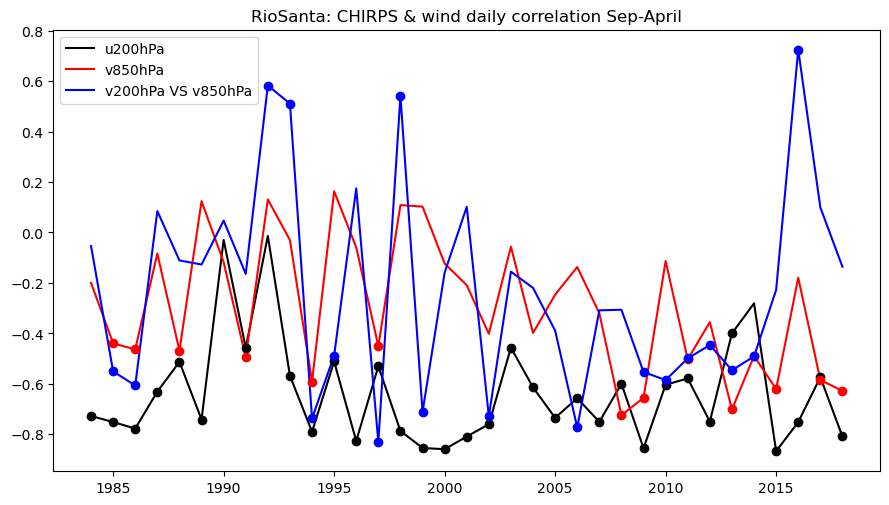

In [27]:
f = plt.figure(figsize=(9,5), dpi=100)
ax = f.add_subplot(111)

valpos2 = np.array(u200_stats['pval'])<0.05
xval2  = (years)[valpos2]
yval2 = np.array(u200_stats['corr'])[valpos2]

valpos8 = np.array(v850_stats['pval'])<0.05
xval8  = (years)[valpos8]
yval8 = np.array(v850_stats['corr'])[valpos8]

valposw = np.array(wind_stats['pval'])<0.05
xvalw  = (years)[valposw]
yvalw = np.array(wind_stats['corr'])[valposw]

plt.plot(years,u200_stats['corr'], linestyle='-', color='k', label='u200hPa')
plt.plot(years,v850_stats['corr'], linestyle='-', color='r', label='v850hPa')
plt.plot(years,np.array(wind_stats['corr'])*(-1), linestyle='-', color='b', label = 'v200hPa VS v850hPa')
                                     
plt.plot(xval2,yval2, marker='o', linestyle='', color='k')
plt.plot(xval8,yval8, marker='o', linestyle='', color='r')
plt.plot(xvalw,yvalw*-1, marker='o', linestyle='', color='b')

plt.legend()
plt.tight_layout()
plt.title('RioSanta: CHIRPS & wind daily correlation Sep-April')
plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/correlation_timeseries_RioSanta_Chirps.jpg')

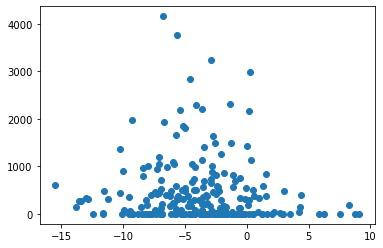

In [25]:
y=1990
plt.scatter(v850ca[v850ca['time.year']==y], cav850[cav850['time.year']==y])